# Extract eddy diffusivity data from Groeskamp et al. (2020) and interpolate them to our section coordinates

In [1]:
import pickle
import h5py
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d

## Load $K_0, K$ data from Groeskamp et al 2020

Downloaded from https://figshare.com/articles/dataset/Groeskamp_et_al_2020_-_mixing_diffusivities/12554555

In [2]:
data_K0 = h5py.File('data/Groeskamp_diffusivity/WOA18_K0.mat', "r")
K0 = data_K0['WOA18_K0']['K0_WOA']

data_K = h5py.File('data/Groeskamp_diffusivity/WOA18_K.mat', "r")
K = data_K['WOA18_K']['K_WOA']

# Coordinates # TODO double check with Sjoerd
data_am = h5py.File('data/WOA_climatology/WOA18_gsw_N2LL_am.mat', "r")

xt = data_am['xt'][:][:,0]
yt = data_am['yt'][:][:,0]
zt = data_am['zt'][:][:,0] 
zt = np.hstack([0, zt[0:]]) # surface level is missing, so we add it manually # TODO check!

In [3]:
# Select subset in Drake Passage
xt_sub = xt[300:307]
yt_sub = yt[28:37]
K0_sub = K0[:, 28:37, 300:307]
K_sub = K[:, 28:37, 300:307]

## Load coordinates from mooring data (depth + location on section)

In [4]:
# Moorings

ds_moorings_sr1b_depth = xr.open_dataset(f'data/variables_from_moorings_SR1b-lat_depth.nc')
depth_moorings = ds_moorings_sr1b_depth.depth
lat_moorings = ds_moorings_sr1b_depth.lat

with open('data/pp_lat_lon.pkl', 'rb') as f:
    pp_lat_lon = pickle.load(f)

lon_moorings = pp_lat_lon(lat_moorings) + 360 # add 360 shift for compatibility with WOA grid

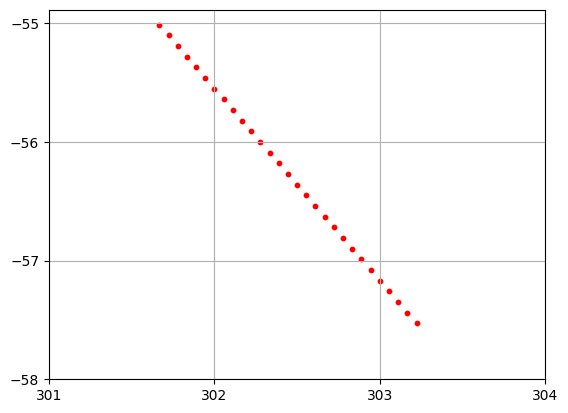

In [5]:
# Checking how many grid cells of the Groeskamp et al data are covered by the moorings
import matplotlib.pyplot as plt
plt.scatter(lon_moorings, lat_moorings, c='r',s=10)
plt.xticks([301,302,303,304])
plt.yticks([-58,-57,-56,-55])
plt.grid(True)

## Interpolate $K_0, K$ to mooring coordinates

In [6]:
# interpolate in x,y
K0_moorings = np.zeros((len(zt), len(lat_moorings)))
K_moorings = np.zeros((len(zt), len(lat_moorings)))
points = np.array([(lat, lon) for lat,lon in zip(lat_moorings,lon_moorings)])
for i in range(len(zt)):
    f_K0 = RegularGridInterpolator((yt_sub, xt_sub), K0_sub[i,:,:], bounds_error=False,fill_value=np.nan)
    f_K = RegularGridInterpolator((yt_sub, xt_sub), K_sub[i,:,:], bounds_error=False,fill_value=np.nan)
    K0_moorings[i,:] = f_K0(points)
    K_moorings[i,:] = f_K(points)

# interpolate in z
K0_moorings_interp = np.zeros((len(depth_moorings), len(lat_moorings)))
K_moorings_interp = np.zeros((len(depth_moorings), len(lat_moorings)))
for i in range(len(lat_moorings)):
    f_K0 = interp1d(zt, K0_moorings[:,i], bounds_error=False, fill_value=np.nan)
    f_K = interp1d(zt, K_moorings[:,i], bounds_error=False, fill_value=np.nan)
    K0_moorings_interp[:,i] = f_K0(depth_moorings)
    K_moorings_interp[:,i] = f_K(depth_moorings)

In [7]:
ds = xr.Dataset({"K0": (["depth", "lat"], K0_moorings_interp),
                 "K": (["depth", "lat"], K_moorings_interp)},
                coords={"depth": depth_moorings, "lat": lat_moorings})
ds.to_netcdf('data/Groeskamp_diffusivity/eddy_diff_Groeskamp.nc')